<a href="https://colab.research.google.com/github/zxyao5148/STAT3612_2023_1A_GroupProject/blob/main/RNN_Transformer/transformer_median.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries classification with a Transformer model

[Code source](https://keras.io/examples/timeseries/timeseries_classification_transformer/)<br>
**Description:** This notebook demonstrates how to do timeseries classification using a Transformer model.

## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [23]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
from sklearn.model_selection import train_test_split

# Raw URLs for the CSV files
train_url = "https://raw.githubusercontent.com/zxyao5148/STAT3612_2023_1A_GroupProject/main/data_processing/train/train_valid_median.csv"
test_url = "https://raw.githubusercontent.com/zxyao5148/STAT3612_2023_1A_GroupProject/main/data_processing/test/test_median.csv"

# Download the CSV files
train_csv = requests.get(train_url).text
test_csv = requests.get(test_url).text

# Read the CSV files into pandas DataFrames
train = pd.read_csv(StringIO(train_csv))
test = pd.read_csv(StringIO(test_csv))

# Split the data into features (X) and target variable (y)
x_train = train.iloc[:,9:]
y_train = train.iloc[:, 8]

x_test = test.iloc[:,8:]

In [24]:
x_train = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

# Reset the index of the y_train DataFrame
y_train = y_train.reset_index(drop=True)

# Shuffle the indices
idx = np.random.permutation(len(x_train))

# Reassign the values using the shuffled indices
x_train = x_train[idx]
y_train = y_train.iloc[idx]

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [26]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [27]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


## Train

In [28]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history=model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 158, 1)]             0         []                            
                                                                                                  
 layer_normalization_16 (La  (None, 158, 1)               2         ['input_3[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_8 (Mu  (None, 158, 1)               7169      ['layer_normalization_16[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_16

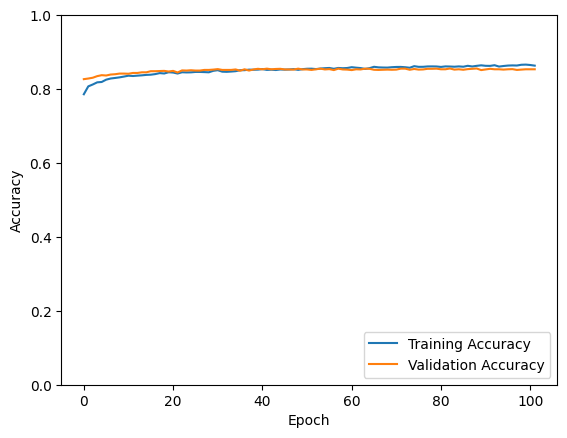

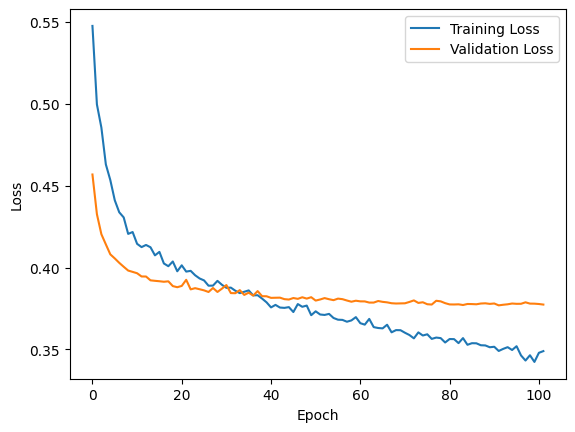

In [29]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [30]:
from sklearn.metrics import roc_auc_score

y_train_pred = model.predict(x_train)
# Convert probabilities to binary predictions
y_train_pred_binary = np.argmax(y_train_pred, axis=1) # Choose the class with the highest probability


363/363 [==============================] - 7s 17ms/step


In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
auc_train = roc_auc_score(y_train, y_train_pred[:, 1])

print(f'Accuracy (train): {accuracy_train:.4f}')
print(f'AUC (train): {auc_train:.4f}')


Accuracy (train): 0.8641
AUC (train): 0.8236


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_train, y_train_pred_binary)
recall = recall_score(y_train, y_train_pred_binary)
f1 = f1_score(y_train, y_train_pred_binary)

# Print with 4 digits limit
print("For training set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4),"\n")

For training set:
Precision: 0.822
Recall: 0.2864
F1 Score: 0.4248 



## Export prediction

In [49]:
y_test_pred = model.predict(x_test)
y_test_pred_binary = np.argmax(y_test_pred, axis=1)

92/92 [==============================] - 2s 25ms/step


In [52]:
# Assuming y_test_pred_binary is a numpy array
predictions_df = pd.DataFrame(y_test_pred_binary, columns=['readmitted_within_30days'])
merged_df = test[['id']].merge(predictions_df, left_index=True, right_index=True)
merged_df.to_csv('predictions.csv', index=False)

from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Hyperparameter Tuning

from sklearn.model_selection import train_test_split

# Define the hyperparameters to search over
hyperparameters = {
    'head_size': [128, 256, 512],
    'num_heads': [2, 4, 8],
    'ff_dim': [4, 8, 16],
    'num_transformer_blocks': [2, 4, 6],
    'mlp_units': [[64], [128], [256]],
    'mlp_dropout': [0.2, 0.4, 0.6],
    'dropout': [0.2, 0.25, 0.3],
}

def train_and_evaluate_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, mlp_dropout, dropout, x_train, y_train, x_val, y_val):
    # Build the model with the given hyperparameters
    model = build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, mlp_dropout, dropout)
    model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
    # Train the model
    model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    # 200 originally
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
)
    # Evaluate the model
    score = model.evaluate(x_val, y_val, verbose=0)

    return score[1]  # Return the validation metric (e.g., accuracy)

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

best_score = 0
best_hyperparameters = None

# Iterate over different sets of hyperparameters and train/evaluate the model
for head_size in hyperparameters['head_size']:
    for num_heads in hyperparameters['num_heads']:
        for ff_dim in hyperparameters['ff_dim']:
            for num_transformer_blocks in hyperparameters['num_transformer_blocks']:
                for mlp_units in hyperparameters['mlp_units']:
                    for mlp_dropout in hyperparameters['mlp_dropout']:
                        for dropout in hyperparameters['dropout']:
                            score = train_and_evaluate_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, mlp_dropout, dropout, X_train, Y_train, X_val, Y_val)
                            if score > best_score:
                                best_score = score
                                best_hyperparameters = {
                                    'head_size': head_size,
                                    'num_heads': num_heads,
                                    'ff_dim': ff_dim,
                                    'num_transformer_blocks': num_transformer_blocks,
                                    'mlp_units': mlp_units,
                                    'mlp_dropout': mlp_dropout,
                                    'dropout': dropout,
                                }

print("Best parameters:", best_hyperparameters)
print("Best score:", best_score)


## Conclusions

In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/timeseries_transformer_classification) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/timeseries_transformer_classification).

In [ ]:
from sklearn.model_selection import train_test_split

# Define the hyperparameters to search over
hyperparameters = {
    'head_size': [128, 256, 512],
    'num_heads': [2, 4, 8],
    'ff_dim': [4, 8, 16],
    'num_transformer_blocks': [2, 4, 6],
    'mlp_units': [[64], [128], [256]],
    'mlp_dropout': [0.2, 0.4, 0.6],
    'dropout': [0.2, 0.25, 0.3],
}

def train_and_evaluate_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, mlp_dropout, dropout, x_train, y_train, x_val, y_val):
    # Build the model with the given hyperparameters
    model = build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, mlp_dropout, dropout)
    model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
    # Train the model
    model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    # 200 originally
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
)
    # Evaluate the model
    score = model.evaluate(x_val, y_val, verbose=0)

    return score[1]  # Return the validation metric (e.g., accuracy)

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

best_score = 0
best_hyperparameters = None

# Iterate over different sets of hyperparameters and train/evaluate the model
for head_size in hyperparameters['head_size']:
    for num_heads in hyperparameters['num_heads']:
        for ff_dim in hyperparameters['ff_dim']:
            for num_transformer_blocks in hyperparameters['num_transformer_blocks']:
                for mlp_units in hyperparameters['mlp_units']:
                    for mlp_dropout in hyperparameters['mlp_dropout']:
                        for dropout in hyperparameters['dropout']:
                            score = train_and_evaluate_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, mlp_dropout, dropout, X_train, Y_train, X_val, Y_val)
                            if score > best_score:
                                best_score = score
                                best_hyperparameters = {
                                    'head_size': head_size,
                                    'num_heads': num_heads,
                                    'ff_dim': ff_dim,
                                    'num_transformer_blocks': num_transformer_blocks,
                                    'mlp_units': mlp_units,
                                    'mlp_dropout': mlp_dropout,
                                    'dropout': dropout,
                                }

print("Best parameters:", best_hyperparameters)
print("Best score:", best_score)
